In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns

In [19]:
def analyze(file):
    """
    Input file in .txt format
    e.g. data-3um-60x-061.txt

    Sample txt file:
    t,x_A,y_A,x_B,y_B,x_C,y_C,x_D,y_D,x_E,y_E,
    0.000,584.0,-263.9,511.4,-211.8,610.0,-250.0,381.5,-226.0,299.0,-170.0
    0.040,584.0,-264.3,511.7,-212.0,609.9,-249.7,381.8,-225.5,298.7,-170.1
    0.080,583.2,-264.3,511.5,-212.1,610.0,-249.5,381.7,-225.3,298.7,-169.8
    """
    df = pd.read_csv(file)
    df = df.drop(df.columns[11], axis=1)
    df.columns = df.columns.str.replace('_', '')

    for label in ['A', 'B', 'C', 'D', 'E']:
        df['y'+label] = df['y'+label].apply(lambda x: x*3e-6/16)
        df['x'+label] = df['x'+label].apply(lambda x: x*3e-6/16)
        df[f'x{label}change'] = df[f'x{label}'] - df[f'x{label}'].iloc[0]
        df[f'y{label}change'] = df[f'y{label}'] - df[f'y{label}'].iloc[0]
        df[f'r2{label}change'] = df[f'x{label}change']**2 + df[f'y{label}change']**2
        
    pd.set_option('display.max_columns', None)
    df['xmean'] = df[['xAchange', 'xBchange', 'xCchange', 'xDchange', 'xEchange']].mean(axis=1)
    df['ymean'] = df[['yAchange', 'yBchange', 'yCchange', 'yDchange', 'yEchange']].mean(axis=1)
    df['rSqMean'] = df[['r2Achange', 'r2Bchange', 'r2Cchange', 'r2Dchange', 'r2Echange']].mean(axis=1)

    model = ols('rSqMean ~ t', data=df).fit()

    # R Squared plot
    plt.figure()
    ax = plt.gca()
    sns.scatterplot(x='t', y='rSqMean', data=df, s=11, ax=plt.gca(), color='orange', label='<R^2>')
    
    error = (3/32*10**-12)
    ax.errorbar(df['t'][::15], df['rSqMean'][::15], yerr=error, fmt='--', color='black', capsize=2)
    ax.plot(df['t'], model._results.params[0] + model._results.params[1] * df['t'], label="OLS fit", color = 'blue')
    ax.set_xlabel("t (seconds)")
    ax.set_ylabel("<R^2> (micrometers^2)")
    ax.set_title(f"R Squared Plot - Trial {file[-7:-4]}")
    ax.set_label("OLS fit")
    plt.legend()
    print(model.summary())
    plt.savefig(f"figures/BM-trial{file[-7:-4]}.png")
    
    # XY plot
    plt.figure()
    
    ax1 = plt.gca()
    sns.scatterplot(x='t', y='xmean', data=df, s=11, color='b', label='<X>', ax=ax1)
    sns.scatterplot(x='t', y='ymean', data=df, s=11, color='g', label='<Y>', ax=ax1)
    error = 3/32*10**-6
    ax1.errorbar(df['t'][::15], df['xmean'][::15], yerr=error, fmt='--', color='black', capsize=2)
    ax1.errorbar(df['t'][::15], df['ymean'][::15], yerr=error, fmt='--', color='black', capsize=2)
    plt.xlabel("t (seconds)")
    plt.ylabel("<X>, <Y> (micrometers)")
    plt.title(f"XY Plot - Trial{file[-7:-4]}")
    plt.savefig(f"figures/XY-trial{file[-7:-4]}.png")
    
    s = model._results.params[1]
    T = 297.15
    a = 3
    n = 910
    k = 6*np.pi*n*a*s/(4*T)

    # calculate chisq for each trial
    i0 = model._results.params[0]
    exp = i0 + s*df['t']
    chisq = sum((df['rSqMean'] - exp)**2/exp)
    print(f"Goodness of Fit Chi Squared: {chisq}")

    df['upper'] = i0 + s*df['t'] + (3/32*10**-12)
    df['lower'] = i0 + s*df['t'] - (3/32*10**-12)

    # create a new column where it is true when the rSqMean is between upper and lower
    df['inRange'] = df['rSqMean'].between(df['lower'], df['upper'], inclusive='both')
    csq = df['inRange'].sum()
    print(f"Chi Squared LR: {csq}")
    return(k)

                            OLS Regression Results                            
Dep. Variable:                rSqMean   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     4981.
Date:                Wed, 01 Nov 2023   Prob (F-statistic):          9.96e-271
Time:                        15:05:11   Log-Likelihood:                 14675.
No. Observations:                 529   AIC:                        -2.935e+04
Df Residuals:                     527   BIC:                        -2.934e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2.548e-14   1.89e-14     -1.350      0.1

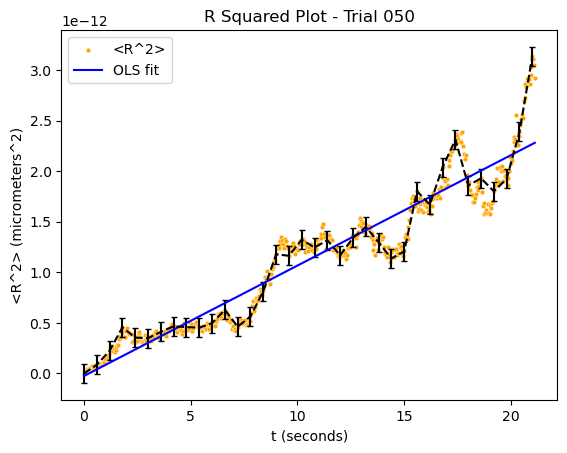

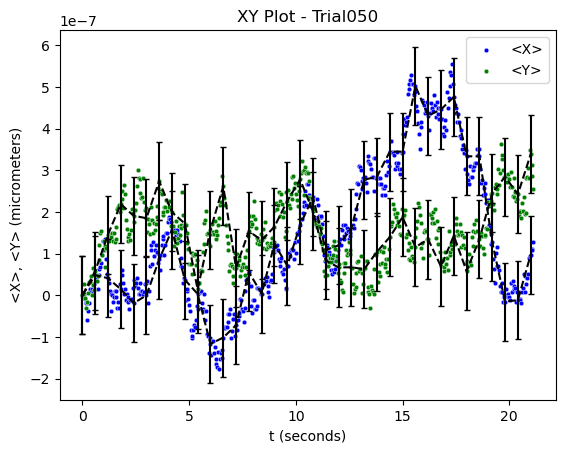

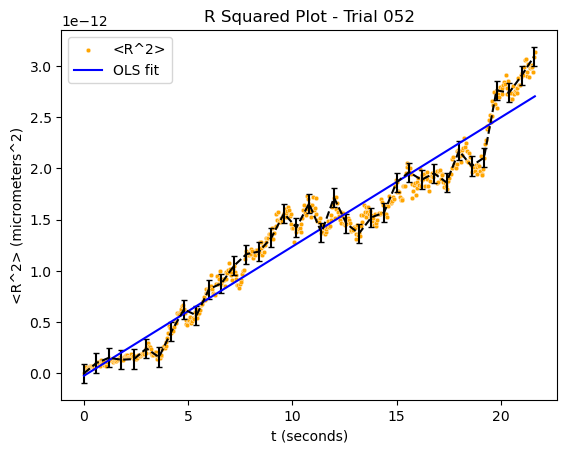

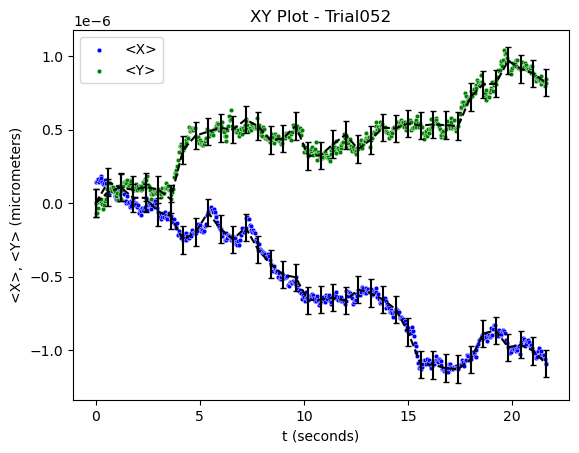

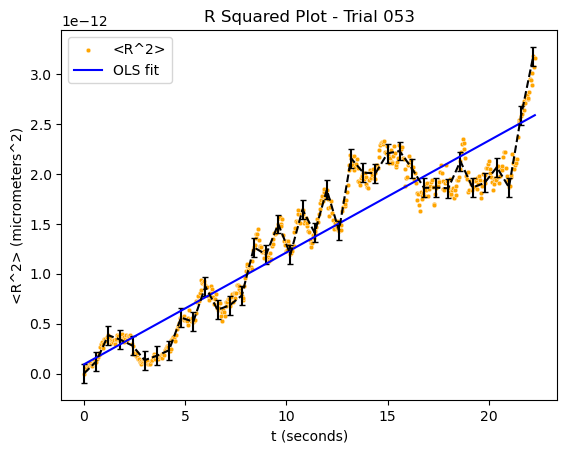

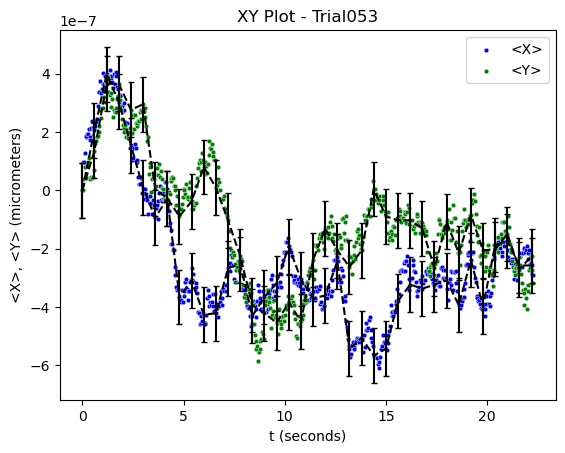

In [20]:
Ks = []
for trial in ["data-3um-60x-050.txt", "data-3um-60x-052.txt", "data-3um-60x-053.txt"]: # "data-3um-60x-061.txt"
    Ks.append(analyze(trial))

In [21]:
actual_K = 1.380649*10**-11
print(Ks)
print(np.mean(Ks))
print((np.array(Ks) - actual_K)/(actual_K))

[4.727699308849284e-12, 5.455957684622242e-12, 4.850292431357855e-12]
5.011316474943127e-12
[-0.65757413 -0.60482659 -0.64869475]


In [22]:
T = 297.15
a = 3
n = 910
s = (np.mean(Ks))*4*T/(a*n*np.pi*6)
multiplicative_error = (0.3/T)**2 + (0.02*10**-12/s)**2 + (0.01*10**-6/a)**2 + (15*10**-6/n)**2 

error = np.sqrt(multiplicative_error) * np.mean(Ks)
print('-RESULTS-')
print(f'ERROR: {np.mean(Ks)} +- {error}') # now convert to J/K
print(f'PERCENTAGE AWAY FROM EXPECTED: {100*(np.mean(Ks) - actual_K)/(actual_K):.2f}%')

-RESULTS-
ERROR: 5.011316474943127e-12 +- 8.658954416775075e-13
PERCENTAGE AWAY FROM EXPECTED: -63.70%
